In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore", message="`should_run_async` will not call `transform_cell` automatically")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import re
import string

In [156]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import string
import os
import re
from numpy import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector
from datetime import datetime as dt
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report
from tensorflow.keras.losses import BinaryCrossentropy
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [183]:
def plot_loss_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['mae'])

    accuracy = np.array(history.history['val_loss'])
    val_accuracy = np.array(history.history['val_mae'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

# Data Downloading

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

! kaggle datasets download -d arashnic/mind-news-dataset
! unzip "/content/mind-news-dataset.zip" -d "/content/dataset"

! kaggle datasets download -d szymonjanowski/internet-articles-data-with-users-engagement
! unzip "/content/internet-articles-data-with-users-engagement.zip" -d "/content/dataset"

 66% 41.0M/61.7M [00:00<00:00, 113MB/s]
100% 61.7M/61.7M [00:00<00:00, 130MB/s]
Archive:  /content/mind-news-dataset.zip
  inflating: /content/dataset/MINDsmall_train/behaviors.tsv  
  inflating: /content/dataset/MINDsmall_train/entity_embedding.vec  
  inflating: /content/dataset/MINDsmall_train/news.tsv  
  inflating: /content/dataset/MINDsmall_train/relation_embedding.vec  
  inflating: /content/dataset/news.tsv/news.tsv  
  0% 0.00/2.54M [00:00<?, ?B/s]
100% 2.54M/2.54M [00:00<00:00, 137MB/s]
Archive:  /content/internet-articles-data-with-users-engagement.zip
  inflating: /content/dataset/articles_data.csv  


# User Preference Based Recommendiation

In [94]:
df = pd.read_csv("/content/dataset/articles_data.csv")

In [95]:
df = df[['source_name', 'author', 'title', 'description', 'top_article', 'engagement_reaction_count', 'engagement_comment_count',
         'engagement_share_count', 'engagement_comment_plugin_count']]

In [96]:
df.duplicated().sum()

66

In [97]:
df.drop_duplicates(inplace=True)

In [98]:
df.isnull().sum()

source_name                           0
author                             1018
title                                 2
description                          24
top_article                           2
engagement_reaction_count           118
engagement_comment_count            118
engagement_share_count              118
engagement_comment_plugin_count     118
dtype: int64

In [99]:
df.dropna(inplace=True)

In [100]:
df['Popularity_Score'] = np.log(df['engagement_reaction_count'] + df['engagement_comment_count'] + df['engagement_share_count'] + df['engagement_comment_plugin_count'] + 1)
df['Popularity_Score'] += 0.001

In [113]:
df.head(5)

,source_name,author,title,description,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,Popularity_Score
0,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,0.0,0.0,0.0,2528.0,0.0,7.836579
1,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,0.0,6.0,10.0,2.0,0.0,2.945439
3,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,0.0,0.0,0.0,7.0,0.0,2.080442
4,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",0.0,0.0,0.0,0.0,0.0,0.001000
5,ABC News,The Associated Press,'This Tender Land' is an affecting story about...,"""This Tender Land"" by William Kent Krueger is ...",0.0,0.0,0.0,0.0,0.0,0.001000


In [115]:
def recommand(author):
  articles = df[(df['author'] == author) & (df['Popularity_Score'] > 7)][['title']]
  return articles

In [116]:
recommand("BBC New")

,title


# News Popularity Prediction Machine Learning

In [79]:
df = pd.read_csv("/content/dataset/articles_data.csv")

In [80]:
df = df[['source_name', 'author', 'title', 'description', 'top_article', 'engagement_reaction_count', 'engagement_comment_count',
         'engagement_share_count', 'engagement_comment_plugin_count']]

In [81]:
df.duplicated().sum()

66

In [82]:
df.drop_duplicates(inplace=True)

In [83]:
df.isnull().sum()

source_name                           0
author                             1018
title                                 2
description                          24
top_article                           2
engagement_reaction_count           118
engagement_comment_count            118
engagement_share_count              118
engagement_comment_plugin_count     118
dtype: int64

In [84]:
df.dropna(inplace=True)

In [85]:
df['Popularity_Score'] = np.log(df['engagement_reaction_count'] + df['engagement_comment_count'] + df['engagement_share_count'] + df['engagement_comment_plugin_count'] + 1)
df['Popularity_Score'] += 0.001

In [87]:
df.head(3)

,source_name,author,title,description,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,Popularity_Score
0,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,0.0,0.0,0.0,2528.0,0.0,7.836579
1,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,0.0,6.0,10.0,2.0,0.0,2.945439
3,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,0.0,0.0,0.0,7.0,0.0,2.080442


In [88]:
tfidf_vec = TfidfVectorizer(ngram_range=(1, 2), dtype=np.float32, sublinear_tf=True, use_idf=True, smooth_idf=True)

In [89]:
train_tfidf = tfidf_vec.fit_transform(df['title'])

In [90]:
X_train, X_test, y_train, y_test = train_test_split(train_tfidf, df['Popularity_Score'], test_size=0.20, random_state=42)

In [91]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print('Model performance for Training set')
print('- MAE: {}'.format(train_mae))
print('- MSE: {}'.format(train_mse))
print('- RMSE: {}'.format(train_rmse))
print('- R2 SCORE: {}'.format(train_r2))
print('----------------------------------')
print('Model performance for Test set')
print('- MAE: {}'.format(test_mae))
print('- MSE: {}'.format(test_mse))
print('- RMSE: {}'.format(test_rmse))
print('- R2 SCORE: {}'.format(test_r2))

Model performance for Training set
- MAE: 2.1348965805322138
- MSE: 6.2701229006996835
- RMSE: 2.504021345895375
- R2 SCORE: 0.14260287617131373
----------------------------------
Model performance for Test set
- MAE: 2.2266476556112713
- MSE: 6.845388080181314
- RMSE: 2.616369255319538
- R2 SCORE: 0.06162253088823888


In [92]:
def title_score(title):
    text = tfidf_vec.transform([title])
    popularity = model.predict(text)
    print("Popularity Score:", round(popularity[0], 2))

In [93]:
title_score("Here Are the States With the Lowest COVID-19 Vaccination Rates");

Popularity Score: 2.95


In [ ]:
pickle.dump(tfidf_vec, open('tfidf_vec.pkl','wb'))
pickle.dump(model, open('popularity_prediction_model.pkl','wb'))

# News Popularity Prediction Deep Learning

In [135]:
df = pd.read_csv("/content/dataset/articles_data.csv")

In [136]:
df = df[['title', 'top_article', 'engagement_reaction_count', 'engagement_comment_count',
         'engagement_share_count', 'engagement_comment_plugin_count']]

In [137]:
df.duplicated().sum()

96

In [138]:
df.drop_duplicates(inplace=True)

In [139]:
df.isnull().sum()

title                                2
top_article                          2
engagement_reaction_count          118
engagement_comment_count           118
engagement_share_count             118
engagement_comment_plugin_count    118
dtype: int64

In [140]:
df.dropna(inplace=True)

In [141]:
df['popularity_Score'] = np.log(df['engagement_reaction_count'] + df['engagement_comment_count'] + df['engagement_share_count'] + df['engagement_comment_plugin_count'] + 1)
df['popularity_Score'] += 0.001

In [142]:
df.head(5)

,title,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,popularity_Score
0,NTSB says Autopilot engaged in 2018 California...,0.0,0.0,0.0,2528.0,0.0,7.836579
1,Unemployment falls to post-crash low of 5.2%,0.0,6.0,10.0,2.0,0.0,2.945439
3,North Korean footballer Han joins Italian gian...,0.0,0.0,0.0,7.0,0.0,2.080442
4,UK government lawyer says proroguing parliamen...,0.0,0.0,0.0,0.0,0.0,0.001000
5,'This Tender Land' is an affecting story about...,0.0,0.0,0.0,0.0,0.0,0.001000


In [143]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # Remove URL from string
    text = re.sub('<.*?>+', ' ', text) # Remove HTML Tags
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # Replace Punctuation with space
    text = re.sub('\n', ' ', text) # Replace NewLine with space
    text = re.sub(r'\w*\d\w*', ' ', text) # Remove alphanumeric
    text = text.replace('-', ' ')
    text = text.replace('’’', '').replace('’', '').replace('‘‘', '').replace('‘', '')
    text = ' '.join(text.split())  # Strip extra spaces
    return text

In [144]:
clean_text("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this ** ?????? ?movie! would you?<br> <br /><br />T")

'in the movie man called tévèz went to a friends pl ce and they had a tensed discussion i dont love this movie would you t'

In [145]:
from sklearn.model_selection import train_test_split

In [146]:
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['popularity_Score'], test_size=0.20)

In [147]:
train_sentences = X_train.apply(clean_text)
test_sentences = X_test.apply(clean_text)
train_sentences = train_sentences.tolist()
test_sentences = test_sentences.tolist()

In [148]:
print("Training Examples:")
len(train_sentences), len(y_train)

Training Examples:


(8176, 8176)

In [149]:
print("Test Examples:")
len(test_sentences), len(y_test)

Test Examples:


(2045, 2045)

In [153]:
sentences_length = [len(sentence.split()) for sentence in df['title']]
avg_sentence_length = np.mean(sentences_length)
print(avg_sentence_length)

10.868506017023774


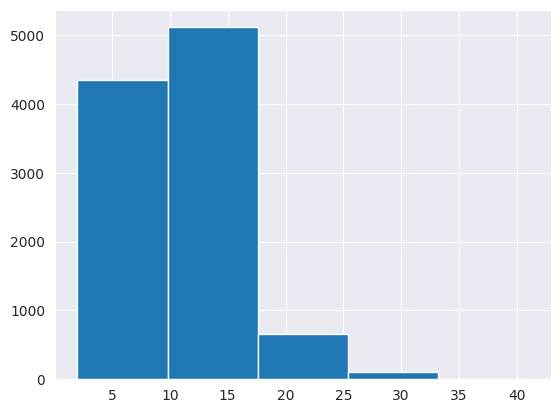

In [154]:
plt.hist(sentences_length, bins=5);

In [155]:
output_sequence_length = int(np.percentile(sentences_length, 95))
print(output_sequence_length)

19


In [162]:
max_tokens = 5000
vectorize_layer = TextVectorization(max_tokens = max_tokens,
                                    output_mode = 'int',
                                    standardize = 'lower_and_strip_punctuation',
                                    output_sequence_length = 19)

vectorize_layer.adapt(df['title'])

In [163]:
random_sentence = random.choice(train_sentences)
print('Sentence:', random_sentence)
print('Length of sentence:', len(random_sentence.split()))
print('Vectorized_Form:', vectorize_layer([random_sentence]))

Sentence: hurricane dorian makes one final stop in the us before racing to canada
Length of sentence: 13
Vectorized_Form: tf.Tensor(
[[  43   38  288   59  275  298    4    3   13  151 2147    2  388    0
     0    0    0    0    0]], shape=(1, 19), dtype=int64)


In [164]:
text_vocab = vectorize_layer.get_vocabulary()
print("Total number of words in vocalbuary", len(text_vocab))
print("The Top Most 5 common words in vocalbuary:", text_vocab[:5])
print("The Least Most 5 common words in vocalbuary:", text_vocab[-5:])

Total number of words in vocalbuary 5000
The Top Most 5 common words in vocalbuary: ['', '[UNK]', 'to', 'the', 'in']
The Least Most 5 common words in vocalbuary: ['owned', 'overlooked', 'overhauled', 'overdose', 'overcrowding']


In [165]:
vectorize_layer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 5000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 19,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 5000}

In [166]:
token_embed = Embedding(input_dim = 5000,
                        output_dim = 128,
                        name = "Embeddings")

In [167]:
target_sentence = random.choice(train_sentences)
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = vectorize_layer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
what to look for in the september jobs report

Sentence after vectorization (before embedding):
[[ 34   2 247   7   4   3 459 330 156   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
[[[-0.04173143 -0.03811419 -0.00064392 ...  0.02437267  0.03404817
    0.03460571]
  [-0.04801032 -0.01024728 -0.04857146 ...  0.0354442  -0.04539935
    0.01205434]
  [-0.03381357  0.01380697 -0.01167536 ... -0.00013523  0.02155954
   -0.03905189]
  ...
  [-0.00904888 -0.04019024 -0.02879502 ...  0.01584568  0.01056622
   -0.03528171]
  [-0.00904888 -0.04019024 -0.02879502 ...  0.01584568  0.01056622
   -0.03528171]
  [-0.00904888 -0.04019024 -0.02879502 ...  0.01584568  0.01056622
   -0.03528171]]]

Embedded sentence shape: (1, 19, 128)


In [168]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, y_test))

In [169]:
for sentences, labels in train_dataset.take(1):
  print("Sentence = ", sentences)
  print("Labels = ", labels)

Sentence =  tf.Tensor(b'saudi aramco picks banks including goldman jpmorgan for ipo roles bloomberg', shape=(), dtype=string)
Labels =  tf.Tensor(0.001, shape=(), dtype=float64)


In [170]:
train_dataset = train_dataset.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

In [171]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [172]:
for sentences, labels in train_dataset.take(1):
  for i in range(5):
    print("Sentence = ", sentences[i])
    print("Labels = ", labels[i])

Sentence =  tf.Tensor(b'saudi aramco picks banks including goldman jpmorgan for ipo roles bloomberg', shape=(), dtype=string)
Labels =  tf.Tensor(0.001, shape=(), dtype=float64)
Sentence =  tf.Tensor(b'a san francisco startup pays its employees to go to burning man their pictures show what it s like to live in the art filled desert festival on the company s dime', shape=(), dtype=string)
Labels =  tf.Tensor(3.4667359027997264, shape=(), dtype=float64)
Sentence =  tf.Tensor(b'one thing you can do switch to a green energy provider', shape=(), dtype=string)
Labels =  tf.Tensor(4.220507705176107, shape=(), dtype=float64)
Sentence =  tf.Tensor(b'historic heat in southern and eastern us as major fall cool down begins', shape=(), dtype=string)
Labels =  tf.Tensor(3.296836866004329, shape=(), dtype=float64)
Sentence =  tf.Tensor(b'antonio brown oakland raiders release wide receiver before opening game', shape=(), dtype=string)
Labels =  tf.Tensor(3.6119179126442242, shape=(), dtype=float64)


In [192]:
input_layer = Input(shape=(1,), dtype=tf.string)
text_vectors = vectorize_layer(input_layer)
token_embeddings = token_embed(text_vectors)
x = LSTM(32)(token_embeddings)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='linear')(x)
model = Model(inputs = input_layer,
                outputs = output_layer)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 19)                0         
 Vectorization)                                                  
                                                                 
 Embeddings (Embedding)      (None, 19, 128)           640000    
                                                                 
 lstm_6 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                           

In [193]:
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam

In [194]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])

In [195]:
history = model.fit(train_dataset,
                    validation_data = test_dataset,
                    epochs = 5)

Epoch 1/5
128/128 [==============================] - 8s 40ms/step - loss: 8.3418 - mae: 2.3279 - val_loss: 8.2317 - val_mae: 2.2767
Epoch 2/5
128/128 [==============================] - 5s 38ms/step - loss: 4.3882 - mae: 1.6141 - val_loss: 8.6642 - val_mae: 2.3357
Epoch 3/5
128/128 [==============================] - 3s 25ms/step - loss: 3.4121 - mae: 1.3842 - val_loss: 9.4483 - val_mae: 2.4046
Epoch 4/5
128/128 [==============================] - 4s 33ms/step - loss: 3.2197 - mae: 1.3488 - val_loss: 9.3893 - val_mae: 2.3932
Epoch 5/5
128/128 [==============================] - 4s 29ms/step - loss: 3.0258 - mae: 1.2928 - val_loss: 9.3881 - val_mae: 2.4099


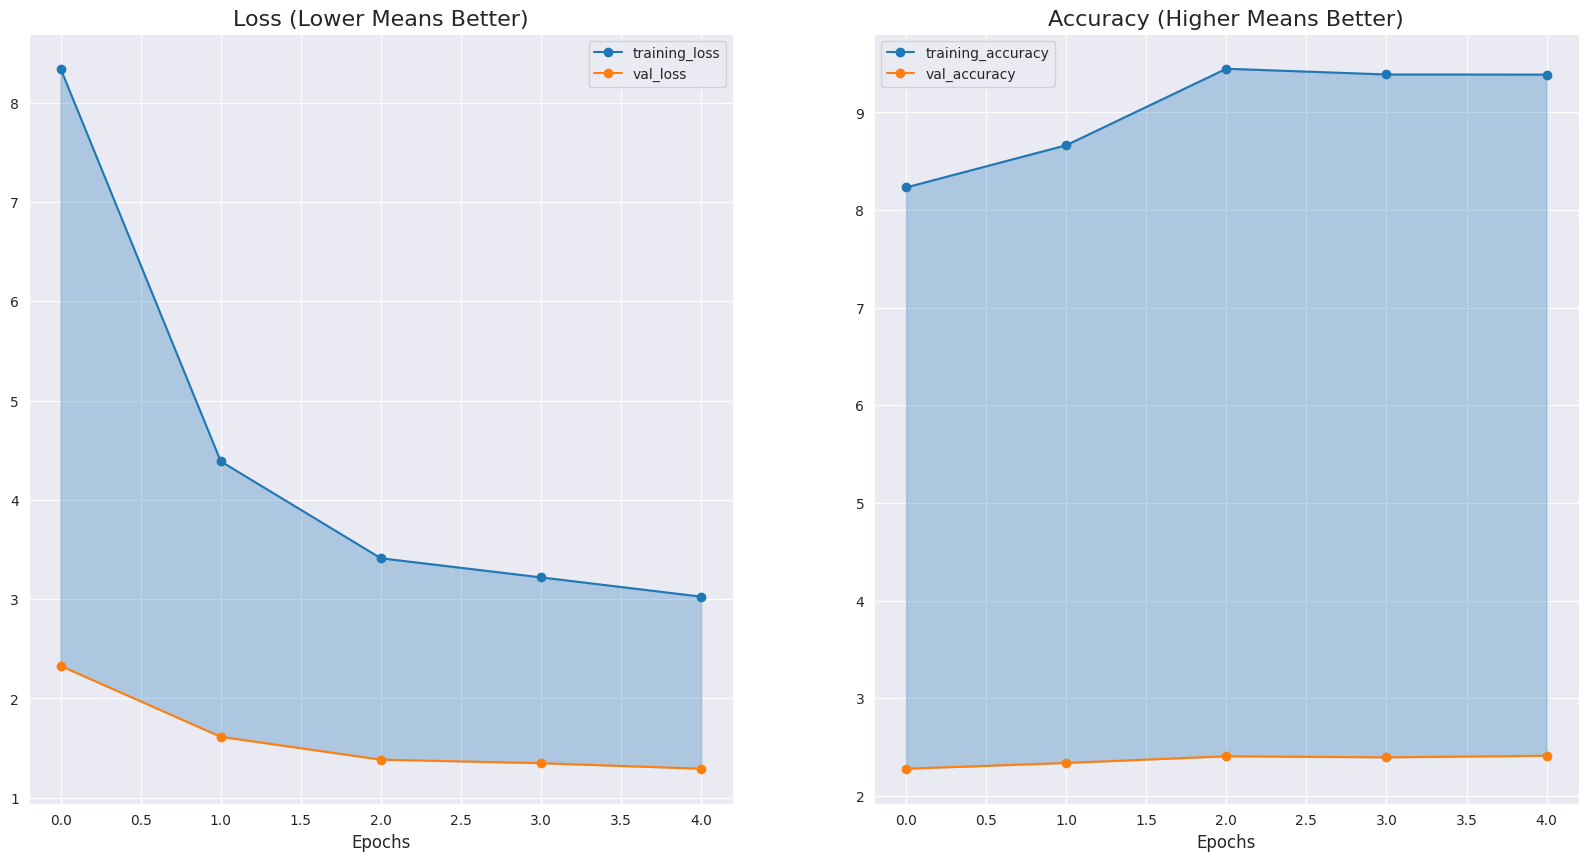

In [196]:
plot_loss_curves(history)

In [197]:
y_train_pred = model.predict(train_dataset, verbose=1)
y_test_pred = model.predict(test_dataset, verbose=1)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print('Model performance for Training set')
print('- MAE: {}'.format(train_mae))
print('- MSE: {}'.format(train_mse))
print('- RMSE: {}'.format(train_rmse))
print('- R2 SCORE: {}'.format(train_r2))
print('----------------------------------')
print('Model performance for Test set')
print('- MAE: {}'.format(test_mae))
print('- MSE: {}'.format(test_mse))
print('- RMSE: {}'.format(test_rmse))
print('- R2 SCORE: {}'.format(test_r2))

32/32 [==============================] - 0s 6ms/step
Model performance for Training set
- MAE: 1.1891919646395344
- MSE: 2.4806738706122298
- RMSE: 1.5750155144036613
- R2 SCORE: 0.6492926009175398
----------------------------------
Model performance for Test set
- MAE: 2.4098809184276826
- MSE: 9.38805458719028
- RMSE: 3.063993242027515
- R2 SCORE: -0.28048651983349826


In [198]:
test_data = tf.data.Dataset.from_tensor_slices([["historic heat in southern and eastern us as major fall cool down begins"]])

In [201]:
model_pred = model.predict(test_data)
model_pred[0][0]

1/1 [==============================] - 0s 46ms/step


5.09372

In [ ]:
model.save("News_Popularity_Prediction")

In [ ]:
loaded_model = tf.load_model("News_Popularity_Prediction")

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices([["historic heat in southern and eastern us as major fall cool down begins"]])
model_pred = loaded_model.predict(test_data)
model_pred[0][0]

# Content Based Recommendiations

In [2]:
df = pd.read_csv('/content/dataset/news.tsv/news.tsv',header=None,sep='\t')

In [3]:
df.columns=['News ID', "Category", "SubCategory", "Title", "Abstract", "URL", "Title Entities", "Abstract Entities"]

In [4]:
df = df[['Category', 'SubCategory', 'Title', 'Abstract']].head(25000)

In [5]:
df.duplicated().sum()

165

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.isnull().sum()

Category          0
SubCategory       0
Title             0
Abstract       1166
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23669 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     23669 non-null  object
 1   SubCategory  23669 non-null  object
 2   Title        23669 non-null  object
 3   Abstract     23669 non-null  object
dtypes: object(4)
memory usage: 924.6+ KB


In [10]:
df.head(5)

,Category,SubCategory,Title,Abstract
0,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the..."
1,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...
2,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...
3,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi..."
4,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re..."
5,sports,football_nfl,Should NFL be able to fine players for critici...,Several fines came down against NFL players fo...
6,weather,weathertopstories,It's been Orlando's hottest October ever so fa...,There won't be a chill down to your bones this...


In [11]:
df.nunique()

Category          16
SubCategory      229
Title          23588
Abstract       23431
dtype: int64

In [12]:
df.describe(include=['object'])

,Category,SubCategory,Title,Abstract
count,23669,23669,23669,23669
unique,16,229,23588,23431
top,news,newsus,Look of the Day,Trailer 1
freq,7219,2717,8,25


In [13]:
df['Data'] = df['Category'] + " "  + df['SubCategory'] + " " + df['Title'] + " " + df['Abstract']

In [14]:
df.head(5)

,Category,SubCategory,Title,Abstract,Data
0,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",lifestyle lifestyleroyals The Brands Queen Eli...
1,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,health weightloss 50 Worst Habits For Belly Fa...
2,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,news newsworld The Cost of Trump's Aid Freeze ...
3,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",health voices I Was An NBA Wife. Here's How It...
4,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...","health medical How to Get Rid of Skin Tags, Ac..."


In [16]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # Remove URL from string
    text = re.sub('<.*?>+', ' ', text) # Remove HTML Tags
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # Replace Punctuation with space
    text = re.sub('\n', ' ', text) # Replace NewLine with space
    text = re.sub(r'\w*\d\w*', ' ', text) # Remove alphanumeric
    text = text.replace('-', ' ')
    text = text.replace('’’', '').replace('’', '').replace('‘‘', '').replace('‘', '')
    text = ' '.join(text.split())  # Strip extra spaces
    return text

In [17]:
df['Data'] = df['Data'].apply(clean_text)

In [18]:
df.head(5)

,Category,SubCategory,Title,Abstract,Data
0,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",lifestyle lifestyleroyals the brands queen eli...
1,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,health weightloss worst habits for belly fat t...
2,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,news newsworld the cost of trump s aid freeze ...
3,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",health voices i was an nba wife here s how it ...
4,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",health medical how to get rid of skin tags acc...


In [19]:
cv = CountVectorizer(max_features=5000, stop_words='english')
vector = cv.fit_transform(df['Data']).toarray()
print("Vectors Shape:", vector.shape)

Vectors Shape: (23669, 5000)


In [20]:
similarity = cosine_similarity(vector)
print("Similarity Shape:", similarity.shape)

Similarity Shape: (23669, 23669)


In [45]:
knn_model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
knn_model.fit(vector)

NearestNeighbors(algorithm='brute', metric='cosine')

In [40]:
title_list = df['Title'].tolist()

In [41]:
def recommend_similarity(headline):
  index = title_list.index(headline)
  similarity_scores = np.argsort(similarity[index])[::-1]
  recommended_titles = [title_list[i] for i in similarity_scores[1:25]]
  print("Recommended Titles:")
  for title in recommended_titles:
      print(title)

In [ ]:
def recommend_knn(headline):
  index = title_list.index(headline)
  vector_represention = vector[index, :].reshape(1, -1)
  distances, indices = knn_model.kneighbors(vector_represention, n_neighbors = 25)
  recommended_titles = [title_list[i] for i in indices[0]]
  print("Recommended Titles:")
  for title in recommended_titles:
      print(title)

In [42]:
recommend_similarity("Trump: Erdogan's decision 'didn't surprise me'")

Recommended Titles:
Kurdish group PKK pens open letter rebuking Trump's comparison to ISIS
Syrian Kurds accuse Turkey of violating ceasefire
In Iraqi refuge, Syrian Kurds curse Trump and Erdogan
Allies believe Trump gave 'green light' to Turkey despite US denials
Turkey, Russia agree on Syrian Kurdish YPG withdrawal, joint patrols -Erdogan
Turkey attacks Kurds who battled ISIS with US forces just days ago
Turkey within Trump red line, US seeking ceasefire: official
'I can't even look at the atrocities': U.S. troops say Trump's Syria withdrawal betrayed an ally
Syrian Arab Fighters Backed by Turkey Kill Two Kurdish Prisoners
Erdogan says Turkey will never declare ceasefire in northern Syria
U.S. chides Turkey for "heading in the wrong direction" in Syria
Trump appears to confirm U.S. nukes are in Turkey, an admission that would break with longstanding protocol
White House Threatens Turkey With Crippling Sanctions
After mixed messages, US piles pressure on Turkey
Syrian Kurdish leader sa

In [ ]:
recommend_knn("Trump: Erdogan's decision 'didn't surprise me'")

In [44]:
recommend_similarity("Walmart Will Now Deliver Groceries Straight to Your Fridge")

Recommended Titles:
Here's Why You Might Love Almonds, But Hate Almond Extract
There's a surprising ingredient missing in Dunkin's jelly doughnuts
9 Things You Might Not Know About Eggnog
A burrito-stuffed bagel now exists   here's what's inside
Twix-Flavored Popcorn Is Here To Make Movie Nights So Much Better
Costco Is Selling BBQ Brisket Slider Kits for the Easiest Weeknight Dinner
20 Home Renovations That Instantly Add Value to Your Home
All of the Thanksgiving Items You Should Buy from Walmart
These 16 New Food Companies Are Changing the Way We Eat
3 new cocktail books for home bartenders of all ability levels, from basic to master
New Home Gadgets Available At The Home & Garden Show
I'm Breaking Up With Butter Because I Love the Earth
All the Snacks Bon Appétit Staffers Stash at Their Desks
I Tried 7 of the Weirdest Products at Trader Joe's so You Don't Have To
You Can Buy A Box Of Frosted Flakes, Froot Loops, And Rice Krispies All Mixed Together For One Day Only
Guy Fieri Opened 

In [ ]:
recommend_knn("Walmart Will Now Deliver Groceries Straight to Your Fridge")

In [ ]:
pickle.dump(title_list, open('title_list.pkl','wb'))
pickle.dump(similarity, open('similarity.pkl','wb'))

In [ ]:
pickle.dump(vector, open('vector.pkl','wb'))
pickle.dump(knn_model, open('knn_model.pkl','wb'))